# Auto ownership estimation

In [1]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables, validate

%load_ext memory_profiler


In [2]:
mm.initialize()

Loading model step 'auto_ownership'
Loading model step 'primary_mode_choice'
Loading model step 'WLCM'


In [3]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

In [4]:
#initialization only
orca.run(['initialize_network_small','initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [5]:
# only if rebuilding networks
# orca.run(['initialize_network_small', 'network_aggregations_small'])
# orca.run(['initialize_network_walk','network_aggregations_walk'])

In [6]:
cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
orca.add_column('households', 'cars_alt', cars_alt)

In [7]:
# income bins
income_bins = pd.cut(orca.get_table('households').to_frame().income,
      bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
      labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
for i in income_bin_dummies.columns:
    orca.add_column('households',i,income_bin_dummies[i])

# tenure type dummy
orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# single family as integer
orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# building type dummy
orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))


In [8]:
%memit parcels = orca.get_table('parcels').to_frame()

peak memory: 11794.04 MiB, increment: 0.00 MiB


In [9]:
# load UrbanAccess transit accessibility variables
am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
am_acc.block_id = am_acc.block_id.str.zfill(15)
parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index) # reorder to align with parcels table

In [10]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [11]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [12]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [13]:
# feature selection with random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, random_state=0)

acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

df = orca.get_table('hh_merged').to_frame()

In [26]:
# balanced sampling
df1 = pd.concat([df[df.cars_alt == 0].sample(10000, random_state = 0),
                df[df.cars_alt == 1].sample(10000, random_state = 0),
                 df[df.cars_alt == 2].sample(10000, random_state = 0),
                 df[df.cars_alt == 3].sample(10000, random_state = 0)
                ])

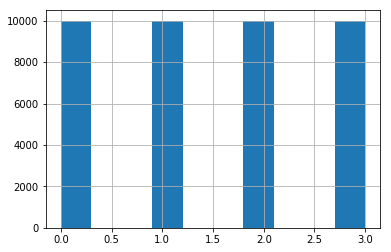

In [27]:
df1['cars_alt'].hist()

In [39]:
X0 = df1[acc_cols + ['persons','age_of_head','workers','children',
         'single_family_int','tenure_1','tenure_2','tenure_3','county_1', 'county_13', 'county_41',
       'county_55', 'county_75', 'county_81', 'county_85', 'county_95',
       'county_97'
        ]
       + list(income_bin_dummies.columns)]
y = df1['cars_alt']

rf.fit(X0,y) 
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

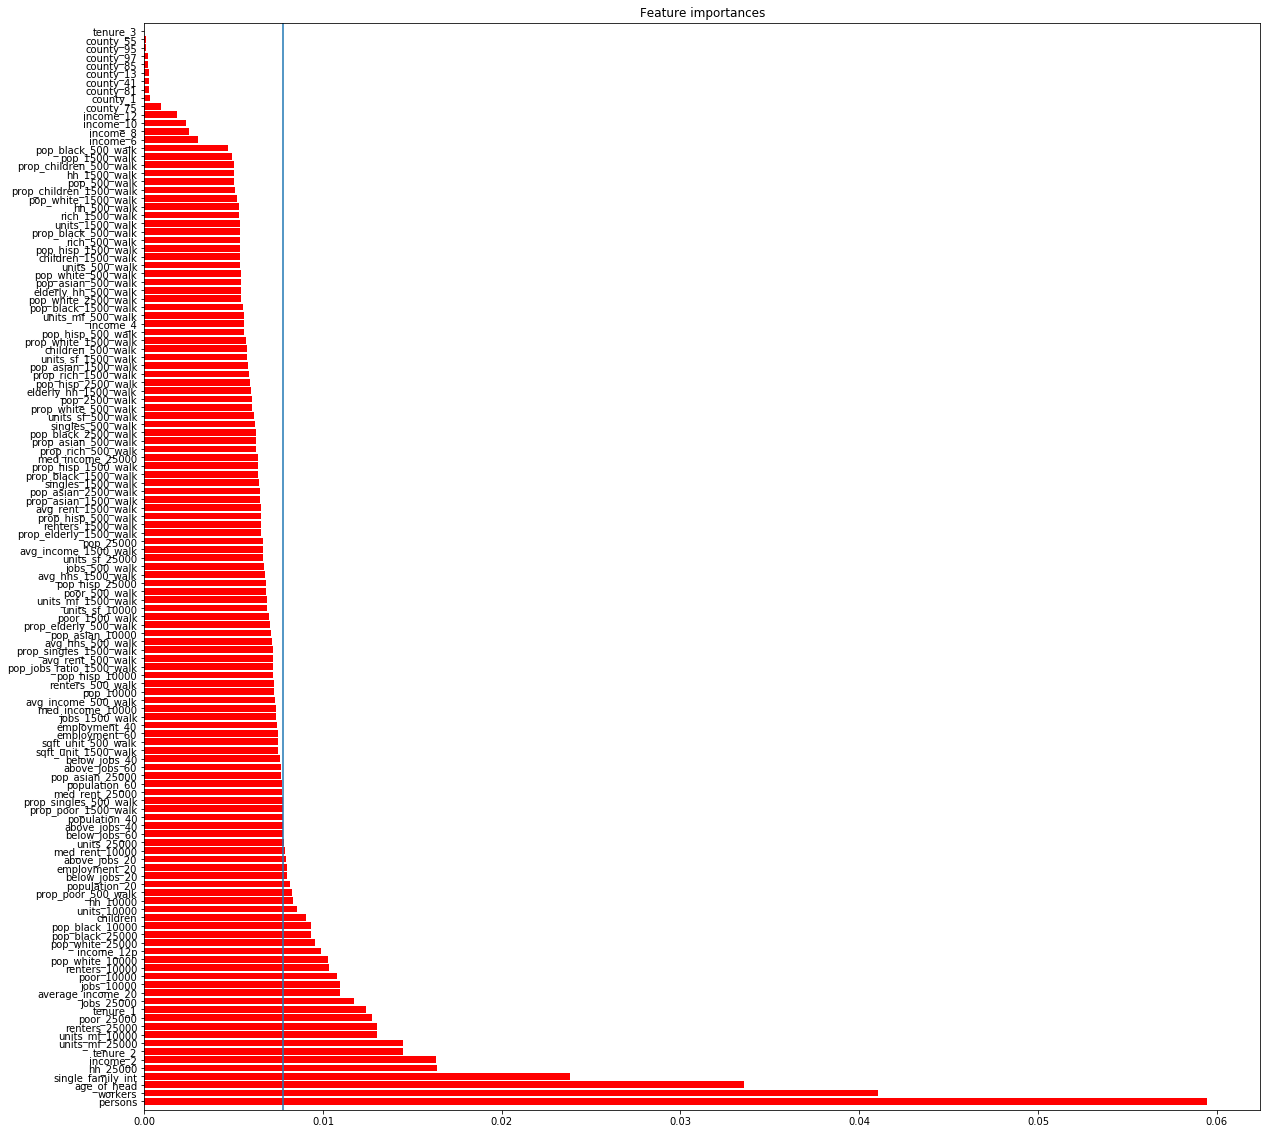

In [40]:
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.barh(range(X0.shape[1]), importances[indices],
       color="r", align="center")
plt.axvline(importances.mean())
plt.yticks(range(X0.shape[1]), X0.columns[indices])
plt.ylim([-1, X0.shape[1]])
plt.show()

In [44]:
# list of above-average features:
X0.columns[importances>importances.mean()]

Index(['units_10000', 'units_mf_10000', 'hh_10000', 'poor_10000',
       'renters_10000', 'jobs_10000', 'med_rent_10000', 'pop_white_10000',
       'pop_black_10000', 'units_25000', 'units_mf_25000', 'hh_25000',
       'poor_25000', 'renters_25000', 'jobs_25000', 'pop_white_25000',
       'pop_black_25000', 'prop_singles_500_walk', 'prop_poor_500_walk',
       'prop_poor_1500_walk', 'population_40', 'below_jobs_20',
       'below_jobs_60', 'employment_20', 'population_20', 'average_income_20',
       'above_jobs_40', 'above_jobs_20', 'persons', 'age_of_head', 'workers',
       'children', 'single_family_int', 'tenure_1', 'tenure_2', 'income_2',
       'income_12p'],
      dtype='object')

In [47]:
# cross validation
df2 = df.sample(30000,random_state = 99)
from sklearn.model_selection import cross_val_score
cross_val_score(rf, df2[X0.columns[importances>importances.mean()]],df2['cars_alt'],cv = 10)

array([0.60093271, 0.62558294, 0.61212929, 0.61512829, 0.61166667,
       0.62166667, 0.62054018, 0.62320774, 0.60973983, 0.62808539])

In [58]:
m2 = SmallMultinomialLogitStep()
m2.name = 'auto_ownership'

In [66]:
m2.model_expression = OrderedDict([
    ('intercept', [1,2,3]), 
    ('income_2',[0]),
    ('income_4',[0]),
    ('income_6',[0,1]),
    ('income_8',[0,1]),
    ('income_10',[1,2,3]),
    ('income_12',[1,2,3]),
    ('income_12p',[1,2,3]),
    ('persons',[1,2,3]),
    ('age_of_head',[1,2,3]),
    ('workers',[1,2,3]),
    ('children',[1,2,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),
    ('tenure_2',[[1,2,3]]),
])

for feature in X0.columns[importances>importances.mean()]:
    if feature not in m2.model_expression:
        m2.model_expression.update({feature:[0]})


In [60]:
m2.tables = ['hh_merged']
m2.choice_column = 'cars_alt'

In [61]:
chooser_ids = orca.get_table('households').to_frame().sample(10000,random_state = 2).index.values # sample 15000 based on household ID
m2.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [67]:
%memit m2.fit()

Log-likelihood at zero: -12,846.7898
Initial Log-likelihood: -12,846.7898
Estimation Time for Point Estimation: 1.55 seconds.
Final log-likelihood: -8,751.9724
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                9,267
Model:             Multinomial Logit Model   Df Residuals:                    9,204
Method:                                MLE   Df Model:                           63
Date:                     Wed, 21 Nov 2018   Pseudo R-squ.:                   0.319
Time:                             02:40:15   Pseudo R-bar-squ.:               0.314
AIC:                            17,629.945   Log-Likelihood:             -8,751.972
BIC:                            18,079.400   LL-Null:                   -12,846.790
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [28]:
m2.tags = ['auto','auto ownership','jayne','test']
m2.register()

Model saved to configs/auto_ownership.pkl
Saving 'auto_ownership.yaml': /home/jayne/ual_model_workspace/fall-2018-models/configs
Loading model step 'auto_ownership'


In [63]:
m2.run()

In [64]:
validate.model_crosstab(m2)

_alt_id,0,1,2,3
_choices,,,,
0,0.059270,0.404928,0.408149,0.127654
1,0.045976,0.348478,0.449953,0.155592
2,0.042662,0.318573,0.466490,0.172275
3,0.044469,0.303244,0.473000,0.179287


In [65]:
validate.tp_rates(m2)

,0,1,2,3,all
True Positive rate,0.05927,0.348478,0.46649,0.179287,0.303037


In [72]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf0 = RandomForestClassifier(n_estimators=100, max_depth=5,
                              random_state=0)
df = orca.get_table('hh_merged').to_frame().sample(15000,random_state = 2)

In [73]:
cols = [item for item in m2.model_expression]
X_mnl = df[list(set(cols) & set(df.columns))]
y = df['cars_alt']
cross_val_score(clf0, X_mnl, y, cv=4)

array([0.48933902, 0.4888    , 0.47932782, 0.50093358])

In [ ]:
acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns)
X0 = df[acc_cols + ['income','persons','age_of_head','workers','children',
         'single_family_int','tenure_1','tenure_2','tenure_3','has_transit','county_1', 'county_13', 'county_41',
       'county_55', 'county_75', 'county_81', 'county_85', 'county_95',
       'county_97'
         
        ]]
y = df['cars_alt']

clf0.fit(X0,y)
importances = clf0.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(X0.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X0.shape[1]), X0.columns[indices],rotation = 90)
plt.xlim([-1, X0.shape[1]])
plt.show()

In [ ]:
X1 = X0[X0.columns[importances>0.01]]
cross_val_score(clf0, X1, y, cv=4)

In [ ]:
# feature used in X1
X1.columns